In [91]:
from netCDF4 import Dataset
import collections
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from pathlib import Path
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd
import glob
import geopandas as gpd
import shapefile as shp 

In [189]:
#fh = Dataset("adaptor.mars.internal-1655727168.606427-18601-13-6d9e5cb6-ff7f-4034-b7f3-b6019b39c9e6.nc",mode='r')
ds = xr.open_dataset("spatially_refined_ladakh.nc",decode_cf=True)
fh = ds
#fh = ds.where((ds.longitude <= 79.5) & (ds.latitude <= 34.5) , drop = True)
# print(fh)
#fh['tcwv'] = fh['tcwv'] *fh['tcwv'].scale_factor + fh['tcwv'].add_offset

# print(fh['tcwv'].attrs)


In [153]:
lons = np.array(fh.variables['longitude'][:])
lats = np.array(fh.variables['latitude'][:])
pwv = np.array(fh.variables['tcwv'][:])
time = np.array(fh.variables['time'][:])


In [154]:
i=0
yearly_data = []
while(i<504):
    pwv_slice = fh['tcwv'][i:i+12]
    yearly_data.append(np.array(pwv_slice))

    i+=12
yearly_data = np.array(yearly_data)



To Save upto N minimum PWV locations for every year; Each minimum value is stored in a different file.

In [162]:
min_upto_val = 10
yearly_data_copy = yearly_data.copy()

for i in range(min_upto_val):
    min_arr =[]
    for year in range(42):
        np.set_printoptions(suppress=True)
        data = yearly_data_copy[year]
        min_val = np.nanmin(data)
        coord = np.unravel_index(np.nanargmin(data),data.shape)
        yearly_data_copy[year][coord[0]][coord[1]][coord[2]] = np.nan
        min_arr.append([year+1980,min_val,coord[0]+1,lats[coord[1]],lons[coord[2]]])
        

    np.savetxt('min_arr_'+str(i+1)+'.txt',min_arr,fmt='%d %f %d %f %f')

    

In [178]:
files=glob.glob("*.txt")

data_to_plot = []
for file in files:
    # if(d!=0):
    #     break

    # d+=1
    file_name = Path(file).stem
    file_number = file_name.split('_')[2]

    min_data = np.loadtxt(file)
    min_loc_data = min_data[:,3:5]
    counter = collections.Counter(map(tuple, min_loc_data))
    df = pd.Series(counter)
    plt.figure(figsize = (10,10))
    plt.bar(range(len(df)), df.values, align='center', width=0.5, color='blue', alpha=0.5, label='min_val',)
    plt.xticks(range(len(df)), df.index.values, size='medium')
    plt.xlabel('Location', fontsize=10)
    plt.ylabel('Frequency',fontsize = 10)
    plt.grid(True)
    plt.title('Locations of '+str(file_number)+' minima in PWV values vs their frequency',fontsize =15)
    plt.savefig(file.replace('.txt','.png'))
    plt.close()



In [242]:

def plot_locations(file,c):
    fontdict={'fontsize': '15', 'fontweight' : '3', 'family' : 'serif', 'color' : '#000000', 'horizontalalignment' : 'center'}
    min_data = np.loadtxt(file)
    min_loc_data = min_data[:,3:5]
    counter = collections.Counter(map(tuple, min_loc_data))
    loc_data = np.array(counter.most_common(10))
    loc_coords = loc_data[:,0]
    lat = np.array([x[0] for x in loc_coords])
    lon = np.array([x[1] for x in loc_coords])
    loc_freq = loc_data[:,1]
    loc_freq = [float(i)*20 for i in loc_freq ] 

    plt.figure(figsize = (10,10))

    m = Basemap(
                llcrnrlat = 32,
                urcrnrlat = 36,
                llcrnrlon = 76,
                urcrnrlon = 80,
                resolution = 'c')
    m.drawcoastlines()

    m.drawparallels(np.arange(32,36,1),labels=[True,False,False,False])
    m.drawmeridians(np.arange(76,80,1),labels=[0,0,0,1])
    m.drawrivers(linewidth=0.5, color='blue')
    m.drawstates(linewidth=0.5, color='blue')
   
    
    plt.scatter(lon,lat,cmap='jet',marker='o',s = loc_freq ,edgecolors='black')

    #c=loc_freq

    sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\IND_adm\IND_adm2.shp")
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]

        plt.plot(x,y,color='black',linewidth=1)
        plt.xlim(xmin = 76, xmax = 80)
        plt.ylim(ymin = 32, ymax = 36)
    plt.grid()
    plt.ylabel('Latitude (°N) ',fontdict = fontdict,labelpad=30)
    plt.xlabel('Longitude (°E)',fontdict = fontdict,labelpad=30)
    m.drawcoastlines()        
    m.drawstates()
    m.drawcountries()
    m.drawmapboundary(fill_color="#DDEEFF")
    plt.plot(79.0002,32.7908,  'o', color='red', markersize=10)
    plt.text(79.0002,32.7908,  'HANLE', fontsize=15)
    plt.title('Locations with minimum PWV: ' + str(c) +' minima', fontsize=20)
    plt.savefig(file.replace('.txt','.jpeg'))
    


C:\Users\TANMAY~1\AppData\Local\Temp/ipykernel_7984/2870654202.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  loc_data = np.array(counter.most_common(10))


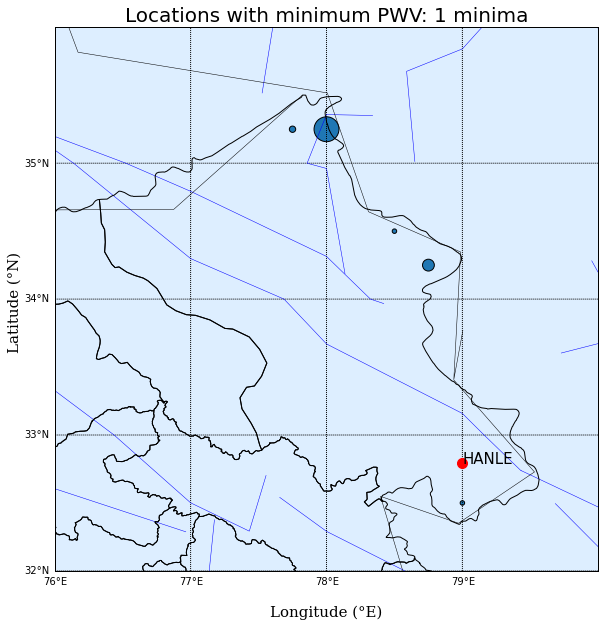

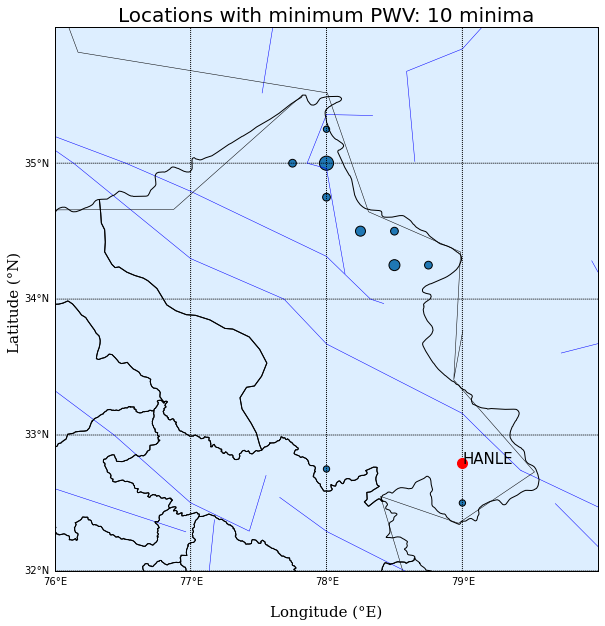

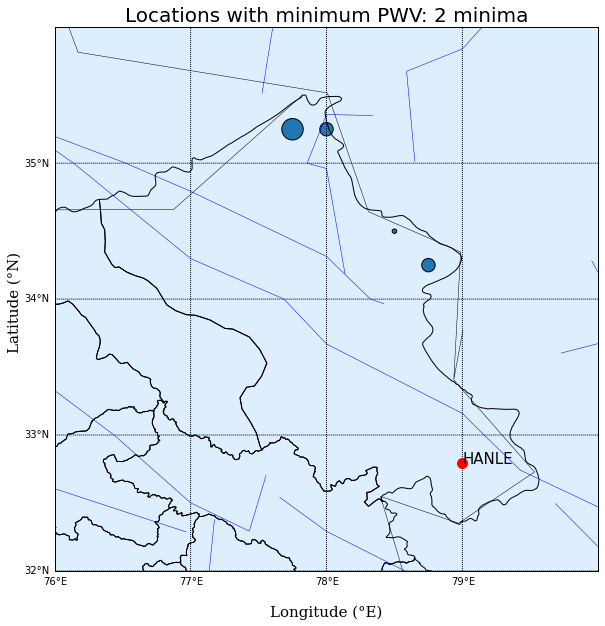

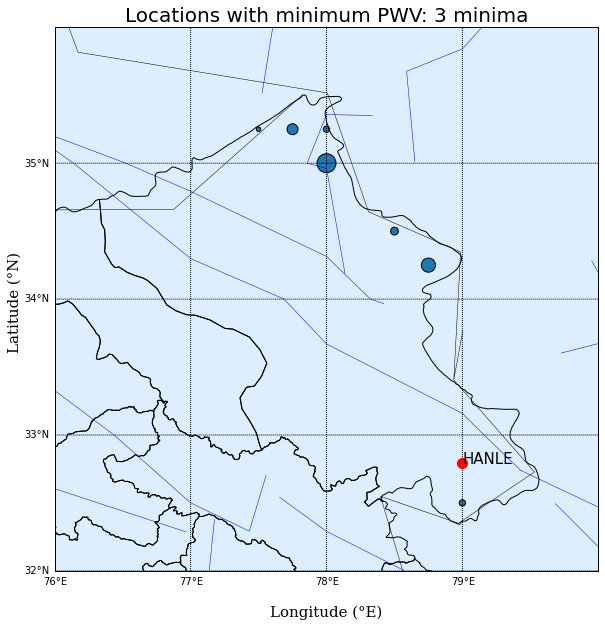

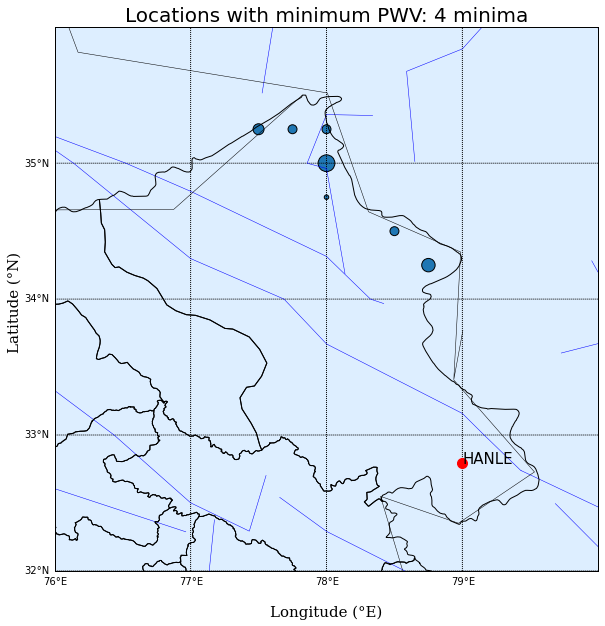

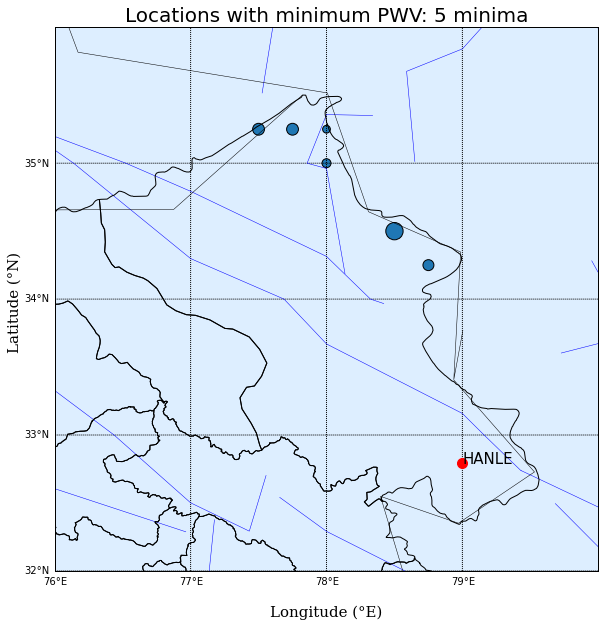

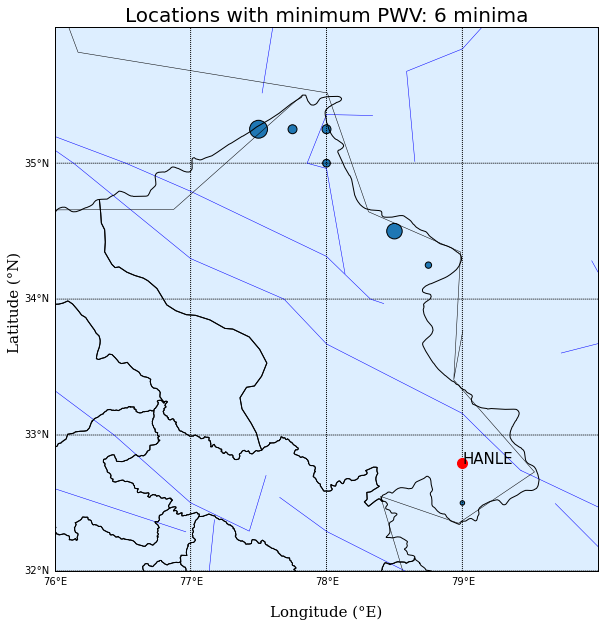

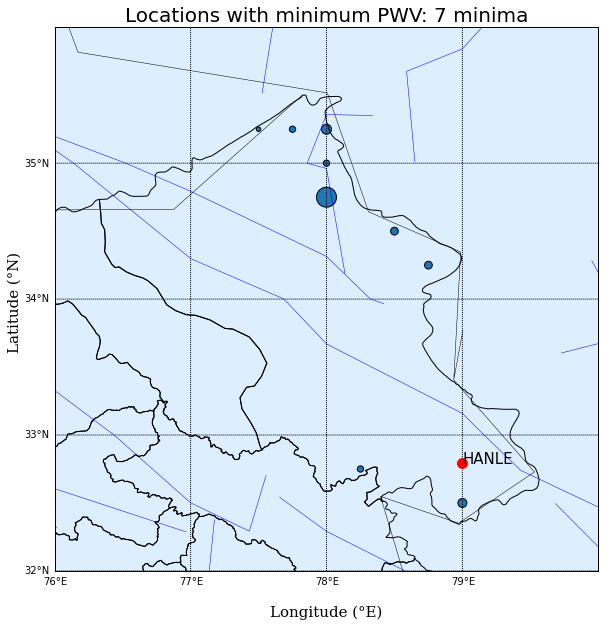

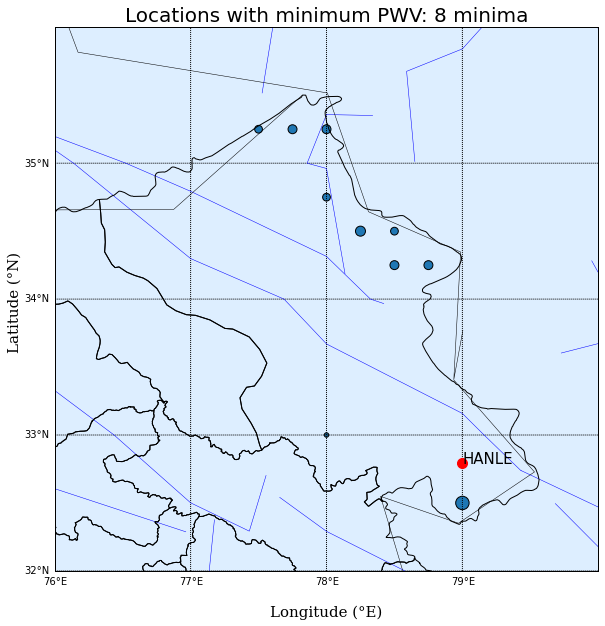

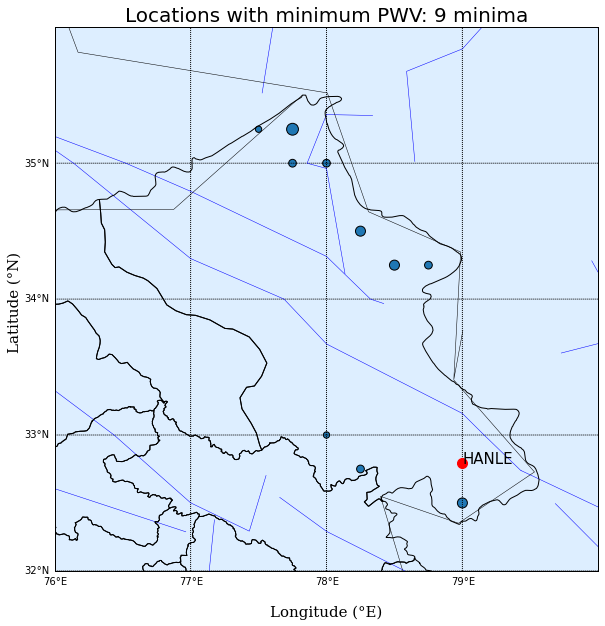

In [243]:

files = glob.glob("*.txt")
for file in files:
    file_name = Path(file).stem
    file_number = file_name.split('_')[2]

    plot_locations(file,c = file_number)


In [238]:

# pwv_data = np.array(fh['tcwv'])
# print(pwv_data.shape)
# pwv_data = np.sort(pwv_data,axis=0)

# print(pwv_data[0][0])
# print(np.nanmin(pwv_data))

# no_of_points = 10
# for i in range(no_of_points):
#     np.set_printoptions(suppress=True)
#     min_val = np.nanmin(pwv_data)
#     coord = np.unravel_index(np.nanargmin(data),data.shape)
#     pwv_data[month][coord[0]][coord[1]] = np.nan

# min_val = np.nanmin(pwv_data)
# coord = np.unravel_index(np.nanargmin(pwv_data),data.shape)
# print(coord)
# # 
# # min_arr =[]
# # for i in range(no_of_points):
    
# #     for month in range(504):
# #         np.set_printoptions(suppress=True)
# #         data = pwv_data[month]
# #         min_val = np.nanmin(data)
# #         coord = np.unravel_index(np.nanargmin(data),data.shape)
# #         pwv_data[month][coord[0]][coord[1]] = np.nan
# #     min_arr.append([month+1,min_val,lats[coord[0]],lons[coord[1]]])
        

# # np.savetxt('abs_min_upto'+str(no_of_points)+'points'+'.txt',min_arr,fmt='%f %f %f %f')


In [188]:
i=0
yearly_data = []
while(i<504):
    pwv_slice = fh['tcwv'][i:i+12]
    yearly_data.append(np.array(pwv_slice))

    i+=12
yearly_data = np.array(yearly_data)

<xarray.Variable (time: 504, latitude: 14, longitude: 15)>
[105840 values with dtype=float32]
Attributes:
    units:          kg m**-2
    long_name:      Total column vertically-integrated water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor
    grid_mapping:   spatial_ref


In [ ]:
def fetch_pwv_details(lat,lon,year,month):

    

    plot_locations(file,c = file_number)
    for i in range(12):
        pwv_data.append(yearly_data[i][lat-1][lon-1])
    return pwv_data